# Processamento e visualização de letras de música

In [154]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import altair as alt
#alt.renderers.enable('notebook')
import seaborn as sns
import re
import os, sys
import nltk
from collections import Counter
from pyvis.network import Network
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from google_trans_new import google_translator
from textblob import TextBlob
import time



# insert dir of python scripts in the path
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.utils import *

In [5]:
module_path

'c:\\Users\\lucas.carneiro\\visualizando_belchior'

In [6]:
artist = 'belchior'
artist_data = artist + '.csv'
# testa se o diretório para salvar visualizações existe
viz_path = os.path.join(module_path, 'visualizations', artist)
if not os.path.isdir(viz_path):
    os.mkdir(viz_path)    
# carrega dados raspados
dataframe_filepath = os.path.join(module_path, 'raw_data', artist_data)
df = pd.read_csv(dataframe_filepath)
df.head()

,título,mais tocada,letra,compositor
0,A Palo Seco,True,Se você vier me perguntar por onde andei No te...,Belchior
1,Aguapé,False,Capineiro de meu pai Não me cortes meus cabelo...,Belchior / CASTRO ALVES / Raimundo Fagner Epig...
2,Alucinação,True,Eu não estou interessado em nenhuma teoria Em ...,Belchior
3,Amor e Crime,False,"Amor, não há amor Existem só provas de amor Ma...",Belchior / francisco Casaverde
4,Apenas Um Rapaz Latino Americano,True,Eu sou apenas um rapaz latino-americano Sem di...,Belchior


# Pré-processamento

In [8]:
# normalização e palavras chave
df['letra normalizada'] = [preprocess(text) for text in df['letra']]
df['palavras-chave'] = [get_keywords(text, 3) for text in df['letra normalizada']]
# tamanho dos textos
df['número de palavras'] = [len(string.split()) for string in df['letra']]
df['número de caracteres'] = [len(string) for string in df['letra']]
# razão entre o número de palavras únicas e o número de palavras no texto
df['variabilidade léxica'] = [len(set(string.split()))/len(string.split()) for string in df['letra']]
df.head(3)

,título,mais tocada,letra,compositor,letra normalizada,palavras-chave,número de palavras,número de caracteres,variabilidade léxica
0,A Palo Seco,True,Se você vier me perguntar por onde andei No te...,Belchior,você vier perguntar onde andei tempo você sonh...,"quero, canto, torto",196,998,0.377551
1,Aguapé,False,Capineiro de meu pai Não me cortes meus cabelo...,Belchior / CASTRO ALVES / Raimundo Fagner Epig...,capineiro pai não cortes cabelos mãe penteou m...,"nada, não, sentada",258,1389,0.577519
2,Alucinação,True,Eu não estou interessado em nenhuma teoria Em ...,Belchior,não interessado nenhuma teoria nenhuma fantasi...,"coisas, nenhuma, amar",372,2103,0.357527


# Termos

In [36]:
lyrics = ' '.join(df['letra normalizada'])
tokens = lyrics.split()
count_tokens = Counter(tokens)
df_term = pd.DataFrame(list(count_tokens.items()), columns = ["termo","frequencia"])
df_term = df_term.sort_values(by='frequencia', ascending=False)
df_term

,termo,frequencia
49,não,276
117,nada,86
225,vida,76
224,amor,75
238,tudo,65
...,...,...
1873,quantas,1
1871,iremos,1
1870,terraço,1
1869,correndo,1


In [39]:
# conta a frequência dos termos
lyrics = ' '.join(df['letra normalizada'])
tokens = lyrics.split()
count_tokens = Counter(tokens)
df_term = pd.DataFrame(list(count_tokens.items()), columns = ["termo","frequencia"])
df_term = df_term.sort_values(by='frequencia', ascending=False)

# músicas onde ocorrem
songs_by_term = []
number_of_songs_by_term = []
for term in df_term['termo']:
    songs = []
    for song, lyric in (zip(df['título'], df['letra normalizada'])):
        if term in lyric.split():
            songs.append(song)

    number_of_songs_by_term.append(len(songs))
    songs = ' '.join(songs)
    songs_by_term.append(songs)

df_term['número de músicas onde o termo ocorre'] = number_of_songs_by_term
df_term['músicas onde o termo ocorre'] = songs_by_term

df_term.head(10)


,termo,frequencia,número de músicas onde o termo ocorre,músicas onde o termo ocorre
49,não,276,69,Aguapé Alucinação Amor e Crime Apenas Um Rapaz...
117,nada,86,18,Aguapé Apenas Um Rapaz Latino Americano Arte F...
225,vida,76,35,Alucinação Apenas Um Rapaz Latino Americano At...
224,amor,75,33,Alucinação Amor e Crime Até Amanhã Balada do A...
238,tudo,65,30,Amor e Crime Apenas Um Rapaz Latino Americano ...
0,você,65,25,A Palo Seco Apenas Um Rapaz Latino Americano B...
39,quero,61,26,A Palo Seco Balada do Amor Bel Prazer Brincand...
1637,medo,60,7,De Primeira Grandeza Medo de Avião Medo de Avi...
495,novo,55,17,Ate Mais Ver Caso Comum de Trânsito Clamor No ...
36,bem,45,18,A Palo Seco Arte Final Balada de Madame Frigid...


In [40]:
# músicas onde mais ocorrem hapaxes
hapaxes = set(df_term[df_term['frequencia']==1]['termo'])
print('quantidade de hapaxes:', len(hapaxes))

hapaxes_count = []
for lyric in df['letra normalizada']:
    tokens = set(lyric.split())
    count = len(tokens.intersection(hapaxes))
    hapaxes_count.append(count)

df['hapaxes'] = hapaxes_count

quantidade de hapaxes: 1849


# Visualizações estáticas

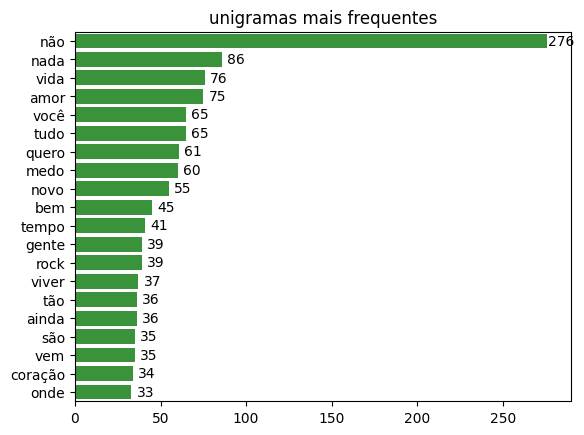

In [63]:
# unigramas
lyrics = ' '.join(list(df['letra normalizada']))
n_grams = (1,1)
total_bigrams = build_ngram_df(lyrics, ngram = n_grams, n=20)
plt.title('unigramas mais frequentes')
plot_ngrams(total_bigrams, col='C2', orientation = 'vertical')

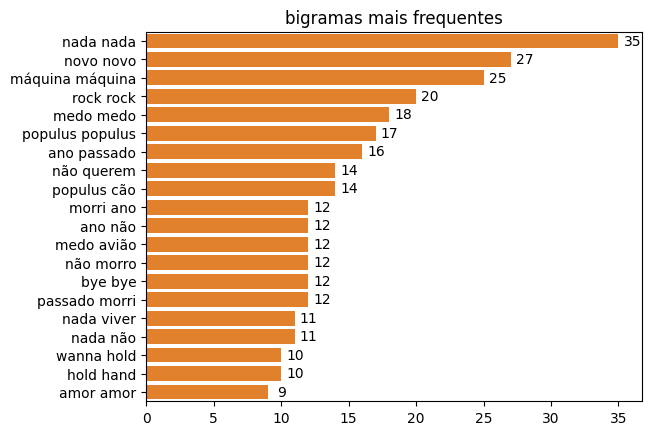

In [64]:
n_grams = (2,2)
total_bigrams = build_ngram_df(lyrics, ngram = n_grams, n=20)
plt.title('bigramas mais frequentes')
plot_ngrams(total_bigrams, col='C1', orientation = 'vertical')

# Tamanho das músicas

In [41]:
df['música mais tocada?'].unique()

array(['É mais tocada', 'Não é mais tocada'], dtype=object)

In [42]:
df['música mais tocada?'] = ['É mais tocada' if x else 'Não é mais tocada' for x in df['mais tocada']]

In [43]:
brush = alt.selection(type='interval')
pts = alt.selection(type="interval", encodings=["x"])

rowbars = alt.Chart(df).mark_bar().encode(
    x='número de palavras:Q',
    y= alt.Y('título:O', sort = alt.EncodingSortField(field="número de palavras", order='descending')),   
    color = 'música mais tocada?:O',
    tooltip=['título', 'número de palavras', 'palavras-chave','letra']
).transform_filter(
    brush
).transform_filter(
    pts
).properties(    
    height= 800,
    width = 300,
    title = 'Quantidade de palavras de cada música'
)


hist_len = alt.Chart(df).mark_bar().encode(
    x = alt.X('número de palavras:Q', bin=alt.Bin(maxbins=30), title='Quantidade de palavras'),
    y = alt.Y('count()',title='Contagem'),
    tooltip = [alt.Tooltip('count():Q', title='Quantidade de letras de letras')]
    #color = alt.condition(pts, alt.value("darkgray"), alt.value("lightgray"))
).properties(
    width = 320,
    height = 200,
    title = 'Histograma da quantidade de palavras por música'
).add_selection(pts)

hist_lex = alt.Chart(df).mark_bar().encode(
    x = alt.X("variabilidade léxica:Q", bin=alt.Bin(maxbins=30),title = 'variabilidade léxica'),
    y =alt.Y('count()',title='Contagem'),
    tooltip = [alt.Tooltip('count():Q', title='Contagem')],
).properties(    
    width = 320,
    height = 200,
    title = 'Histograma da variabilidade léxica'
).add_selection(pts)

hist_hap = alt.Chart(df).mark_bar().encode(
    x = alt.X("hapaxes:Q", bin=alt.Bin(maxbins=30),title = 'quantidade de hapaxes'),
    y =alt.Y('count()',title='Contagem'),
    tooltip = [alt.Tooltip('count():Q', title='Contagem')],
).properties(    
    width = 320,
    height = 200,
    title = 'Histograma de quantidade de hapaxes'
).add_selection(pts)

points = alt.Chart(df).mark_circle().encode(
    x='número de palavras:Q',
    y='variabilidade léxica:Q',
    color= 'música mais tocada?:O', #, alt.value('lightgray', alt.value('lightgray')),
    tooltip=['título','número de palavras','variabilidade léxica','letra'],
    size='hapaxes:Q'
).properties(    
    title = 'Número de palavras por variabilidade léxica'
).add_selection(
    brush
).transform_filter(
    pts
)

hconcat = alt.hconcat(
    rowbars,
    hist_len,
    hist_lex,
    hist_hap,
    points,
    data=df
)

hconcat = (rowbars | (hist_len & hist_lex & hist_hap) | points)

file = 'palavras_por_musicas.html'
filepath = os.path.join(viz_path, file)
hconcat.save(filepath)
hconcat


c:\Users\lucas.carneiro\Miniconda3\envs\belchior\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.HConcatChart(...)

# Frequência das palavras

In [44]:
df_term.head(2)

,termo,frequencia,número de músicas onde o termo ocorre,músicas onde o termo ocorre
49,não,276,69,Aguapé Alucinação Amor e Crime Apenas Um Rapaz...
117,nada,86,18,Aguapé Apenas Um Rapaz Latino Americano Arte F...


In [45]:
df_most_f = df_term.sort_values(by = 'frequencia', ascending = False)[0:50]
df_most_l = df_term.sort_values(by = 'número de músicas onde o termo ocorre', ascending = False)[0:50]


word_freq = alt.Chart(df_most_f).mark_bar().encode(
    x='frequencia:Q',
    y= alt.X('termo:O', sort = alt.EncodingSortField(field="frequencia", order='descending')),
    color = alt.value('steelblue'),
    tooltip=[
        'termo:O',
        'frequencia:Q',
        alt.Tooltip('músicas onde o termo ocorre:O', title='Letras onde o termo ocorre')
    ]
).properties(    
    height=850,
    width = 300,
    title = 'Termos mais frequentes no total da obra'
)

lyrics_count = alt.Chart(df_most_l).mark_bar().encode(
    x='número de músicas onde o termo ocorre:Q',
    y= alt.X('termo:O', 
                sort = alt.EncodingSortField(field="número de músicas onde o termo ocorre", order='descending')),
    color = alt.value('steelblue'),
    tooltip=[
        'termo:O',
        'número de músicas onde o termo ocorre:Q',
        alt.Tooltip('músicas onde o termo ocorre:O', title='Letras onde o termo ocorre')
    ]
).properties(    
    height=850,
    width = 300,
    title = 'Termos que ocorrem em mais músicas'
)

hconcat = alt.hconcat(
    word_freq,
    lyrics_count,
)

hconcat = (word_freq | lyrics_count)

file = 'frequencia_dos_termos.html'
filepath = os.path.join(viz_path, file)
hconcat.save(filepath)
hconcat

c:\Users\lucas.carneiro\Miniconda3\envs\belchior\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.HConcatChart(...)

In [46]:
# hapaxes
hapaxes_df = df_term[df_term['frequencia']==1]
print('Total de hapaxes:', len(hapaxes_df))
for hapaxe, lyrics in zip(hapaxes_df['termo'], hapaxes_df['músicas onde o termo ocorre']):
    print(hapaxe + ': ' + lyrics)

Total de hapaxes: 1849
baianos: Os Derradeiros Moicanos
batidas: Os Derradeiros Moicanos
perguntes: Arte Final
barrocos: Os Derradeiros Moicanos
terno: Os Derradeiros Moicanos
drugs: Arte Final
cheinha: Onde Jazz Meu Coração?
masques: Os Derradeiros Moicanos
martinique: Os Derradeiros Moicanos
mastigando: Onde Jazz Meu Coração?
henri: Os Derradeiros Moicanos
palhinha: Os Derradeiros Moicanos
quantos: Os Derradeiros Moicanos
radares: Os Derradeiros Moicanos
rara: Onde Jazz Meu Coração?
antenas: Os Derradeiros Moicanos
taquara: Onde Jazz Meu Coração?
rachada: Onde Jazz Meu Coração?
desbocada: Onde Jazz Meu Coração?
perturbe: Arte Final
garganta: Onde Jazz Meu Coração?
último: Arte Final
direitinha: Onde Jazz Meu Coração?
palmeiras: Os Derradeiros Moicanos
lustrada: Arte Final
macacos: Os Derradeiros Moicanos
guaranis: Os Derradeiros Moicanos
luís: Os Derradeiros Moicanos
bandas: Onde Jazz Meu Coração?
chateubriand: Os Derradeiros Moicanos
salvação: Os Derradeiros Moicanos
mercadores: Art

# Matriz de similaridade

In [135]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(list(df['letra normalizada']))
cosine_sim = cosine_similarity(X,X)
df_similar = pd.DataFrame(cosine_sim, columns = df['título'], index = df['título'])
df_similar['título'] = df['título']

source = df_similar.melt(id_vars=['título'])
source.columns = ['música i', 'música j', 'similaridade']
source['música j'] = list(df['título'])*len(df['título'])
source.head()

,música i,música j,similaridade
0,A Palo Seco,A Palo Seco,1.000000
1,A Palo Seco,Aguapé,0.000000
2,A Palo Seco,Alucinação,0.000000
3,A Palo Seco,Amor e Crime,0.010159
4,A Palo Seco,Apenas Um Rapaz Latino Americano,0.039606


In [138]:
alt.data_transformers.disable_max_rows()
matrix_sim = alt.Chart(source).mark_rect().encode(
    x='música i:O',
    y='música j:O',
    color=alt.Color('similaridade:Q', scale=alt.Scale(scheme="inferno")),
    tooltip=[
        alt.Tooltip('música i:O', title='Letra i'),
        alt.Tooltip('música j:O', title='Letra j'),
        alt.Tooltip('similaridade:Q', title='Similaridade'),
    ]
).properties(    
    width = 700,
    height= 700,    
    title = 'Matriz de similaridade entre letras'
)

file = 'similaridade_musicas.html'
filepath = os.path.join(viz_path, file)
matrix_sim.save(filepath)
matrix_sim

alt.Chart(...)

# Grafo de co-ocorrência

In [57]:
bigrams = build_ngram_df(df['letra normalizada'], ngram = (2,2), n=None,)
max_range = None
bigrams

ngrams = [(t.split()[0],t.split()[1]) for t in bigrams.index[0:max_range]]
values = [int(i) for i in bigrams.values[0:max_range]]
d = dict(zip(ngrams,values))

net = Network(width = '1250', height = '800px',notebook = True, directed=True)
# Create connections between nodes
for k in d:
    #print(k[0] + "," + k[1] + str(d[k]))
    net.add_node(k[0], label = k[0], value = d[k])
    net.add_node(k[1], label = k[1], value = d[k])
    net.add_edge(k[0], k[1], weight = d[k])

#net.show_buttons(filter_=['physics'])
file = 'rede_co_ocorrencia.html'
filepath = os.path.join(viz_path, file)
net.save_graph(file)
# net.show(file)

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


# Análise de sentimentos

In [196]:
# testa se a polaridade já foi calculada. senão calcula - pode demorar um pouco
def classify_sentiment(pol):
    if pol >= 0.1:
        return 'Positivo'
    elif pol >= -0.1:
        return 'Neutro'
    else:
        return 'Negativo'

if 'polaridade' not in df.columns:
    polarities = []
    subjectivities = []
    for lyric in df['letra']:
        translator = google_translator()  
        detect_result = translator.detect(lyric)
        original_language = detect_result[0]
        translate_text = translator.translate(lyric, lang_tgt='en')
        blob = TextBlob(translate_text)
        polarities.append(blob.sentiment.polarity) 
        subjectivities.append(blob.sentiment.subjectivity)
        time.sleep(1)
    df['polaridade'] = polarities
    df['subjetividade'] = subjectivities
    df['sentimento'] = df.apply(lambda x: classify_sentiment(x['polaridade']),axis=1)

    df.to_csv(dataframe_filepath, index = False)


In [195]:
# visualização interativa

brush = alt.selection(type='interval')

pts = alt.selection(type="interval", encodings=["x"])

points = alt.Chart(df).mark_circle().encode(
    x='polaridade:Q',
    y='subjetividade:Q',
    color=alt.condition(brush, 'sentimento:N', alt.value('lightgray')),
    tooltip=['título','polaridade','subjetividade','letra'],
    size='número de palavras:Q'
).properties(    
    title = 'Polaridade x Subjetividade'
).add_selection(
    brush
).transform_filter(
    pts
)

bars = alt.Chart(df).mark_bar().encode(
    y=alt.Y('sentimento:N', title = 'Categorias de polaridade'),
    color='sentimento:N',
    x=alt.X('count(sentimento):Q', title = 'Contagem'),
    tooltip = [alt.Tooltip('count():Q', title='Contagem')],
).properties(    
    title = 'Categorias de Polaridade'
).transform_filter(
    brush
).transform_filter(
    pts
)

hist_pol = alt.Chart(df).mark_bar().encode(
    x = alt.X("polaridade:Q", bin=alt.Bin(maxbins=30),title = 'polaridade'),
    y =alt.Y('count()',title='Contagem'),
    tooltip = [alt.Tooltip('count():Q', title='Contagem')],
    color = alt.condition(pts, 'sentimento:N', alt.value("lightgray"))
).properties(    
    width = 320,
    height = 200,
    title = 'Histograma da polaridade'
).add_selection(pts)


hist_sub = alt.Chart(df).mark_bar().encode(
    x = alt.X("subjetividade:Q", bin=alt.Bin(maxbins=30),title = 'subjetividade'),
    y =alt.Y('count()',title = 'Contagem'),
    tooltip = [alt.Tooltip('count():Q', title='Contagem')],
    color = alt.condition(pts, alt.value("lightblue"), alt.value("lightgray"))
).properties(    
    width = 320,
    height = 200,
    title = 'Histograma da subjetividade'
).add_selection(pts)

sent = alt.hconcat(
    points & bars,
    hist_pol & hist_sub,
    data=df
)

pol = alt.Chart(df).mark_bar().encode(
    y="polaridade:Q",
    x= alt.X("título:O", sort = alt.EncodingSortField(field="polaridade", order='descending')),
    tooltip = ['título','polaridade','letra'],
    color= 'sentimento'
).properties(
    width=800,
    height = 300,
    title = 'Polaridade das letras'
).transform_filter(
    pts
)

sent = ((points & bars) | (hist_sub & hist_pol)) & pol
sent.properties(title = 'Análise de Sentimentos')
file = 'analise_sentimentos.html'
filepath = os.path.join(viz_path, file)
sent.save(filepath)
sent

c:\Users\lucas.carneiro\Miniconda3\envs\belchior\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)